## Import Required Libraries

In [1]:
# common libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import re
import helper 
import sklearn
import warnings
warnings.filterwarnings('ignore')

# machine learning libraries    
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier   
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import make_scorer

import pydotplus    
from IPython.display import Image
from six import StringIO
from sklearn.tree import export_graphviz
import itertools

## Load Data

In [2]:
# read csv file
data = pd.read_csv('../data/new_merged_data.csv')

print('Shape of dataframe prior to modeling:', data.shape)
display(data.head())

Shape of dataframe prior to modeling: (1321, 423)


,patdeid,rsa_week_0,rsa_week_1,rsa_week_2,rsa_week_3,rsa_week_4,rsa_week_5,rsa_week_6,rsa_week_7,rsa_week_8,...,medication,weeks_attended,cows_predose,cows_postdose,rbs_sexual_activity,rbs_cocaine,rbs_heroine,rbs_amphetamines,rbs_other_opiates,gender
0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,27,11,6,1.0,0.0,30.0,0.0,0.0,1.0
1,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,27,8,1,1.0,0.0,30.0,0.0,0.0,1.0
2,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,27,8,5,1.0,23.0,30.0,0.0,0.0,1.0
3,4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,2.0,27,11,9,1.0,2.0,30.0,0.0,1.0,2.0
4,6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,3,11,6,1.0,0.0,4.0,0.0,26.0,2.0


## Review Tests

In [3]:
test_names = [
 #'Propoxyphene',
 #'Amphetamines',
 #'Cannabinoids',
 #'Benzodiazepines',
 #'MMethadone',
 #'Oxycodone',
 #'Cocaine',
 #'Methamphetamine',
 'Opiate300'
 ]

# define prefix parameter and call helper function to build the dataset
prefix = 'test_'
tests = helper.feature_selection(data, prefix, test_names)


Shape of tests DataFrame: (1321, 5)


,test_Opiate300_0,test_Opiate300_1,test_Opiate300_2,test_Opiate300_3,test_Opiate300_4
0,1.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,0.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...
1316,1.0,1.0,1.0,1.0,1.0
1317,1.0,1.0,1.0,1.0,1.0
1318,1.0,1.0,1.0,1.0,1.0
1319,1.0,1.0,1.0,1.0,1.0


## Review Surveys


In [4]:
# comment out the drugs you don't want to include
survey_names = [
#'cannabis',
#'cocaine',
#'alcohol',
#'oxycodone',
#'mmethadone',
#'amphetamine',
#'methamphetamine',
'opiates',
#'benzodiazepines'
]

# call helper function to build  the dataset
prefix = 'survey_'
surveys = helper.feature_selection(data, prefix, survey_names)

Shape of tests DataFrame: (1321, 2)


,survey_opiates_0,survey_opiates_4
0,30.0,0.0
1,30.0,5.0
2,30.0,9.0
3,30.0,6.0
4,5.0,0.0
...,...,...
1316,20.0,0.0
1317,0.0,0.0
1318,30.0,0.0
1319,30.0,0.0


## Create Dataframe for Baseline Numeric Predictors

In [5]:
# medication data, included up to week 4
group = 'meds'
columns = 10
meds = data[[col for col in data.columns if group in col]].iloc[:, :columns]

# clinical opiate withdrawal scale -  included for assessment
cows = data[[col for col in data.columns if 'cows' in col]]

# rbs - risk behavior survey data
rbs = data[[col for col in data.columns if 'rbs' in col]]

# combine all the dataframes
num_df = pd.concat([tests, surveys, meds, cows, rbs], axis=1)
print('Shape of numeric dataframe after feature selection:', num_df.shape)
display(num_df)

Shape of numeric dataframe after feature selection: (1321, 24)


,test_Opiate300_0,test_Opiate300_1,test_Opiate300_2,test_Opiate300_3,test_Opiate300_4,survey_opiates_0,survey_opiates_4,meds_methadone_0,meds_buprenorphine_0,meds_methadone_1,...,meds_buprenorphine_3,meds_methadone_4,meds_buprenorphine_4,cows_predose,cows_postdose,rbs_sexual_activity,rbs_cocaine,rbs_heroine,rbs_amphetamines,rbs_other_opiates
0,1.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,8.0,0.0,...,192.0,0.0,384.0,11,6,1.0,0.0,30.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,30.0,5.0,0.0,8.0,0.0,...,60.0,0.0,48.0,8,1,1.0,0.0,30.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,30.0,9.0,30.0,0.0,170.0,...,0.0,360.0,0.0,8,5,1.0,23.0,30.0,0.0,0.0
3,1.0,1.0,0.0,1.0,1.0,30.0,6.0,0.0,16.0,0.0,...,160.0,0.0,64.0,11,9,1.0,2.0,30.0,0.0,1.0
4,1.0,1.0,1.0,1.0,1.0,5.0,0.0,0.0,16.0,0.0,...,0.0,0.0,0.0,11,6,1.0,0.0,4.0,0.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1316,1.0,1.0,1.0,1.0,1.0,20.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,14,6,1.0,0.0,30.0,0.0,0.0
1317,1.0,1.0,1.0,1.0,1.0,0.0,0.0,150.0,0.0,0.0,...,0.0,0.0,0.0,12,5,0.0,0.0,0.0,0.0,0.0
1318,1.0,1.0,1.0,1.0,1.0,30.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,15,6,1.0,2.0,30.0,1.0,0.0
1319,1.0,1.0,1.0,1.0,1.0,30.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,16,7,1.0,0.0,30.0,0.0,0.0


## Review Categorical Data

In [6]:
# demographic features
dem = data[['gender']]

print('shape of the categorical df:',dem.shape)
display(dem)

shape of the categorical df: (1321, 1)


,gender
0,1.0
1,1.0
2,1.0
3,2.0
4,2.0
...,...
1316,2.0
1317,2.0
1318,1.0
1319,1.0


## Assign Target Variable and Merge

In [7]:
# assigne dropout variable
dropout = data['dropout']

# merge
new_data = pd.concat([num_df, dem, dropout], axis=1)

print('Shape of new datframe:',new_data.shape)
display(new_data)


Shape of new datframe: (1321, 26)


,test_Opiate300_0,test_Opiate300_1,test_Opiate300_2,test_Opiate300_3,test_Opiate300_4,survey_opiates_0,survey_opiates_4,meds_methadone_0,meds_buprenorphine_0,meds_methadone_1,...,meds_buprenorphine_4,cows_predose,cows_postdose,rbs_sexual_activity,rbs_cocaine,rbs_heroine,rbs_amphetamines,rbs_other_opiates,gender,dropout
0,1.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,8.0,0.0,...,384.0,11,6,1.0,0.0,30.0,0.0,0.0,1.0,0.0
1,1.0,1.0,1.0,1.0,1.0,30.0,5.0,0.0,8.0,0.0,...,48.0,8,1,1.0,0.0,30.0,0.0,0.0,1.0,0.0
2,1.0,1.0,1.0,1.0,1.0,30.0,9.0,30.0,0.0,170.0,...,0.0,8,5,1.0,23.0,30.0,0.0,0.0,1.0,0.0
3,1.0,1.0,0.0,1.0,1.0,30.0,6.0,0.0,16.0,0.0,...,64.0,11,9,1.0,2.0,30.0,0.0,1.0,2.0,0.0
4,1.0,1.0,1.0,1.0,1.0,5.0,0.0,0.0,16.0,0.0,...,0.0,11,6,1.0,0.0,4.0,0.0,26.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1316,1.0,1.0,1.0,1.0,1.0,20.0,0.0,0.0,0.0,0.0,...,0.0,14,6,1.0,0.0,30.0,0.0,0.0,2.0,1.0
1317,1.0,1.0,1.0,1.0,1.0,0.0,0.0,150.0,0.0,0.0,...,0.0,12,5,0.0,0.0,0.0,0.0,0.0,2.0,1.0
1318,1.0,1.0,1.0,1.0,1.0,30.0,0.0,0.0,0.0,0.0,...,0.0,15,6,1.0,2.0,30.0,1.0,0.0,1.0,1.0
1319,1.0,1.0,1.0,1.0,1.0,30.0,0.0,0.0,2.0,0.0,...,0.0,16,7,1.0,0.0,30.0,0.0,0.0,1.0,1.0


## Split the Data to Dev and Test sets

In [8]:

# assign variables
X, y = new_data.drop(columns='dropout'), new_data['dropout']

# create the dev and test sets 
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.14, random_state=42)

# create the train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.16, random_state=42)

# check the shape of the train, validation, and test sets
print('Shape of X_train:', X_train.shape)
print('Shape of X_val:', X_val.shape)
print('Shape of X_test:', X_test.shape)



Shape of X_train: (954, 25)
Shape of X_val: (182, 25)
Shape of X_test: (185, 25)


## Review Patient Profile

In [9]:
X_train.iloc[22, :]

test_Opiate300_0          1.0
test_Opiate300_1          1.0
test_Opiate300_2          1.0
test_Opiate300_3          1.0
test_Opiate300_4          1.0
survey_opiates_0         30.0
survey_opiates_4          3.0
meds_methadone_0          0.0
meds_buprenorphine_0      8.0
meds_methadone_1          0.0
meds_buprenorphine_1    110.0
meds_methadone_2          0.0
meds_buprenorphine_2     90.0
meds_methadone_3          0.0
meds_buprenorphine_3     72.0
meds_methadone_4          0.0
meds_buprenorphine_4     90.0
cows_predose             20.0
cows_postdose             3.0
rbs_sexual_activity       1.0
rbs_cocaine               0.0
rbs_heroine              30.0
rbs_amphetamines          0.0
rbs_other_opiates         0.0
gender                    1.0
Name: 1131, dtype: float64

## Fit A Decision Tree
No hyperparameter tuning

In [10]:
dt = DecisionTreeClassifier(max_depth=None, random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

## Measure the Train and Test with C-Index

In [11]:
y_train_preds = dt.predict_proba(X_train)[:, 1]
print(f"Train C-Index: {helper.cindex(y_train.values, y_train_preds)}")

y_val_preds = dt.predict_proba(X_val)[:, 1]
print(f"Val C-Index: {helper.cindex(y_val.values, y_val_preds)}")

Train C-Index: 1.0
Val C-Index: 0.6085781000368686


## Update Hyperparams

In [12]:
# Update hyperparam configuration
dt_hyperparams = {
    

    
    'criterion': 'gini', 
    'max_depth': 3, 
    'max_features': None, 
    'min_samples_leaf': 1, 
    'min_samples_split': 2
    }

## Let's test the accuracy on a regularlized tree

In [13]:
dt_reg = DecisionTreeClassifier(**dt_hyperparams, random_state=10)
dt_reg.fit(X_train, y_train)

y_train_preds = dt_reg.predict_proba(X_train)[:, 1]
y_val_preds = dt_reg.predict_proba(X_val)[:, 1]
print(f"Train C-Index: {helper.cindex(y_train.values, y_train_preds)}")
print(f"Val C-Index (expected > 0.6): {helper.cindex(y_val.values, y_val_preds)}")

Train C-Index: 0.820981240981241
Val C-Index (expected > 0.6): 0.7857932899102863


## See how the data fits the tree

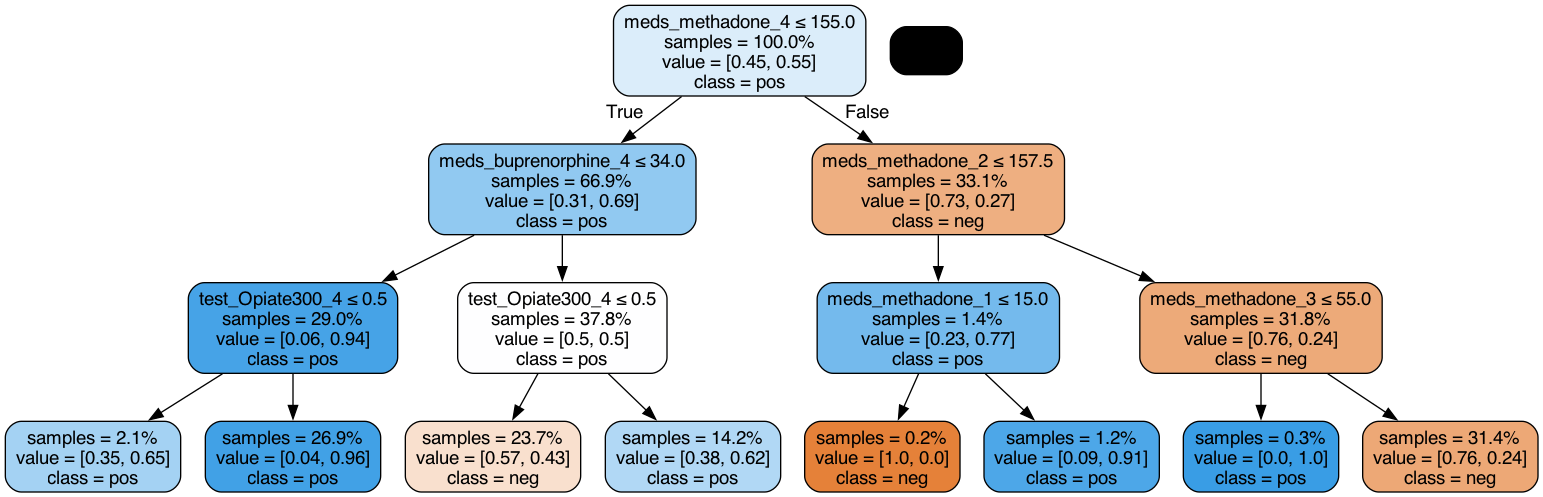

In [14]:
dot_data = StringIO()
export_graphviz(dt_reg, feature_names=X_train.columns, out_file=dot_data,  
                filled=True, rounded=True, proportion=True, special_characters=True,
                impurity=False, class_names=['neg', 'pos'], precision=2)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## Use Grid Search
We will create a reusable function to perform grid search with any classifier

In [15]:
# create custom grid search function
def perform_grid_search(X_train, y_train, X_val, y_val, classifier, hyperparams):
    """
    Perform grid search with cross-validation for a given classifier and hyperparameters.

    Parameters:
    - X_train: Training features dataframe.
    - y_train: Training target series.
    - X_val: Validation features dataframe.
    - y_val: Validation target series.
    - classifier: The classifier to use (e.g., XGBClassifier()).
    - hyperparams: Dictionary of hyperparameters to search.

    Returns:
    - results_df: Pandas DataFrame containing the results of the grid search.
    """
    # Define a custom scoring function for the C-index
    def cindex_score(y_true, y_pred):
        return helper.cindex(y_true, y_pred)

    # Wrap the custom scoring function using make_scorer
    cindex_scorer = make_scorer(cindex_score, greater_is_better=True)

    # Set up GridSearchCV with cross-validation and custom scorer
    grid_search = GridSearchCV(estimator=classifier, param_grid=hyperparams, cv=5, scoring=cindex_scorer, n_jobs=-1, verbose=1)

    # Fit GridSearchCV to the training data
    grid_search.fit(X_train, y_train)

    # Retrieve the best parameters
    best_params = grid_search.best_params_
    
    # Retrieve the best model
    best_model = grid_search.best_estimator_

    # Get the probability scores from the best model
    y_val_preds = best_model.predict_proba(X_val)[:, 1]

    # Calculate the C-index on the validation set
    c_index = helper.cindex(y_val.values, y_val_preds)
    
    # Store the results in a DataFrame
    results = pd.DataFrame(grid_search.cv_results_)

    return results


## Define Param Grid and loop through pipelines

In [16]:
# Define the classifiers and hyperparameters

classifiers = {
    'Logistic Regression': (LogisticRegression(), {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    }),
    'Random Forest': (RandomForestClassifier(), {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4],
        'min_samples_split': [2, 5, 10]
    }),
    'XGBoost': (XGBClassifier(), {
        'max_depth': [3, 4],
        'learning_rate': [0.001, 0.01, 0.1, 0.2],
        'n_estimators': [100, 200, 300],
        'reg_alpha': [0, 0.5, 1],
        'reg_lambda': [0, 0.5, 1]
    })
}

# store results in a dictionary
results = {}

# Perform grid search for each classifier
for clf_name, (clf, params) in classifiers.items():
    print(f"Running grid search for {clf_name}...")
    results[clf_name] = perform_grid_search(X_train, y_train, X_val, y_val, clf, params)
    print()


# print the best results for each classifier
for clf_name, _ in classifiers.items():
    best_cindex = results[clf_name]['mean_test_score'].max()
    best_params = results[clf_name]['params'][results[clf_name]['mean_test_score'].idxmax()]
    print(f"Best C-index for {clf_name}: {best_cindex:.4f}")
    print(f"Best hyperparameters: {best_params}")
    print()

Running grid search for Logistic Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Running grid search for Random Forest...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Running grid search for XGBoost...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Best C-index for Logistic Regression: 0.7337
Best hyperparameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

Best C-index for Random Forest: 0.7409
Best hyperparameters: {'max_depth': 4, 'min_samples_split': 5, 'n_estimators': 100}

Best C-index for XGBoost: 0.7428
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 1, 'reg_lambda': 1}



## Run each classifier with the best params on the test set

In [17]:
# run each classifier with the best params on the test set
for clf_name, (clf, params) in classifiers.items():
    # Initialize the classifier
    clf.set_params(**results[clf_name].loc[results[clf_name]['rank_test_score'] == 1, 'params'].iloc[0])

    # Fit the model
    clf.fit(X_train, y_train)

    # Get the probability scores
    y_test_preds = clf.predict_proba(X_test)[:, 1]

    # Calculate the C-index
    c_index = helper.cindex(y_test.values, y_test_preds)
    print(f"{clf_name} C-index for Test Set: {c_index:.2f}")
    print()

Logistic Regression C-index for Test Set: 0.81

Random Forest C-index for Test Set: 0.81

XGBoost C-index for Test Set: 0.78



## Plot Confusion Matrix with Precision Score

Logistic Regression Precision Score: 0.78
Logistic Regression Recall Score: 0.74

Random Forest Precision Score: 0.76
Random Forest Recall Score: 0.67

XGBoost Precision Score: 0.77
XGBoost Recall Score: 0.65



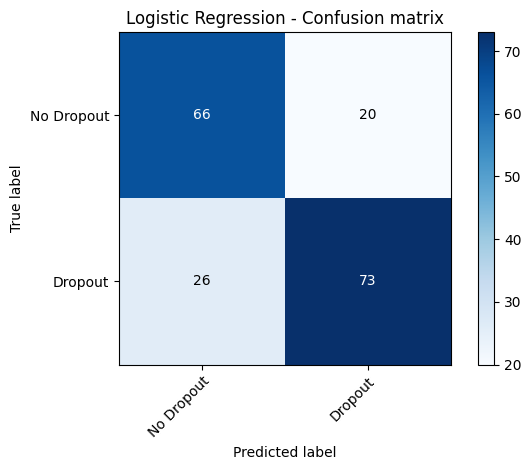

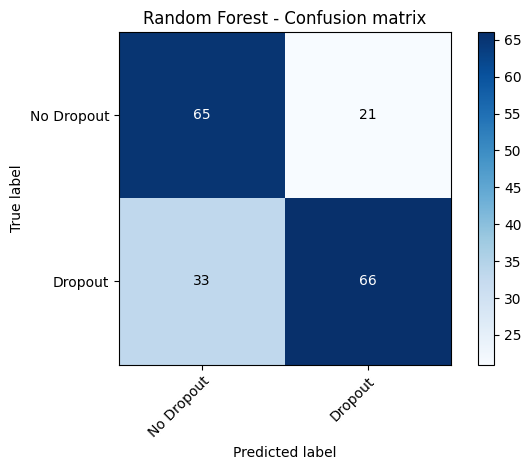

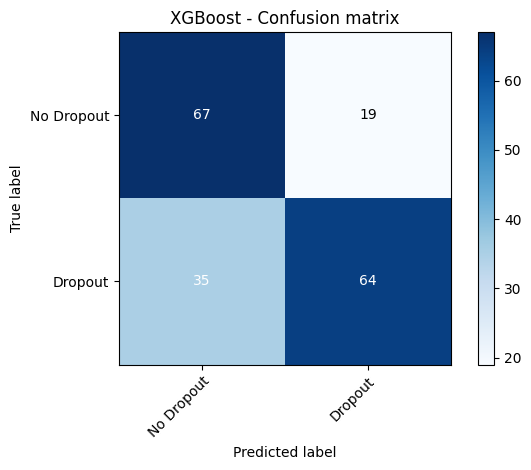

In [18]:
from sklearn.metrics import precision_score, recall_score

# Assuming y_test contains the true labels and y_test_preds contains the predicted labels
for clf_name, (clf, params) in classifiers.items():
    # Initialize the classifier
    clf.set_params(**results[clf_name].loc[results[clf_name]['rank_test_score'] == 1, 'params'].iloc[0])

    # Fit the model
    clf.fit(X_train, y_train)

    # Get the predicted labels
    y_test_preds = clf.predict(X_test)

    # calculate recall
    recall = recall_score(y_test, y_test_preds, pos_label=1.0)  # Adjust pos_label as needed

    # Calculate precision
    precision = precision_score(y_test, y_test_preds, pos_label=1.0)  # Adjust pos_label as needed
    
    # Plot the precision right before each confusion matrix
    print(f'{clf_name} Precision Score: {precision:.2f}')
    print(f'{clf_name} Recall Score: {recall:.2f}')
    print()

    # plot confusion matrix
    helper.plot_confusion_matrix(y_test, y_test_preds, classes=['No Dropout', 'Dropout'],
                          title=f'{clf_name} - Confusion matrix')

## Plot Feature Importance

In [19]:
# create classifier object
xgb = classifiers['XGBoost'][0].set_params(**results['XGBoost'].loc[results['XGBoost']['rank_test_score'] == 1, 'params'].iloc[0])


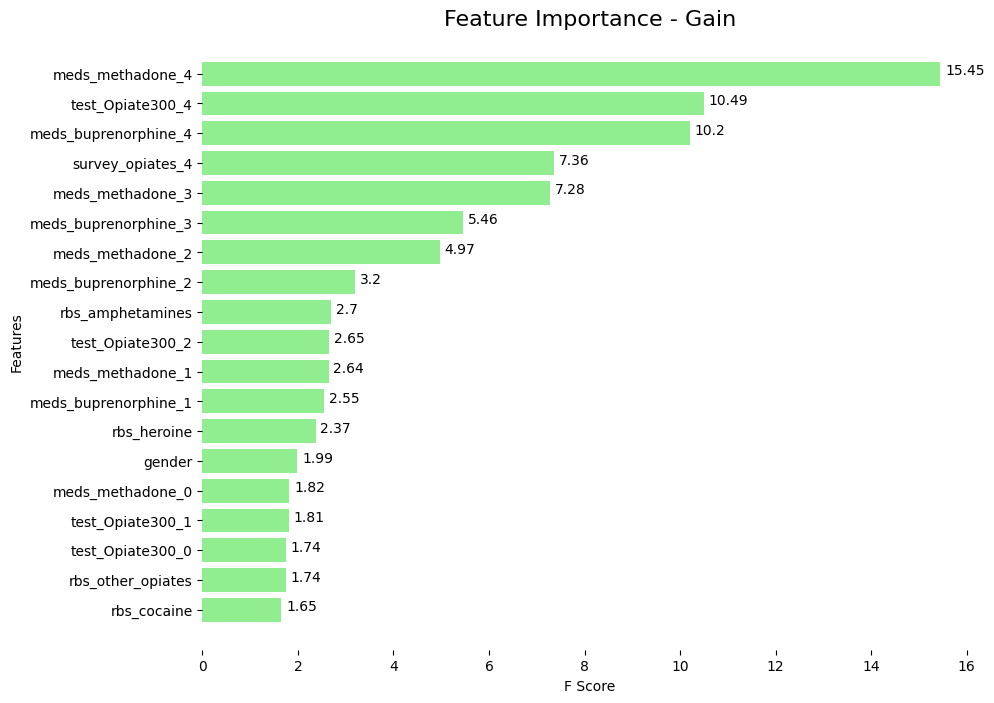

In [20]:
# call helper function to plot feature importance
helper.plot_feature_importance(xgb, X_train, metric="gain", num_features=19)

## Create Shapley Values to Explain the Model

In [21]:
import shap

ex = shap.Explainer(xgb.predict_proba, X_train, max_evals=700)
shap_values = ex(X_test)

Class index: 1
Data index: 169


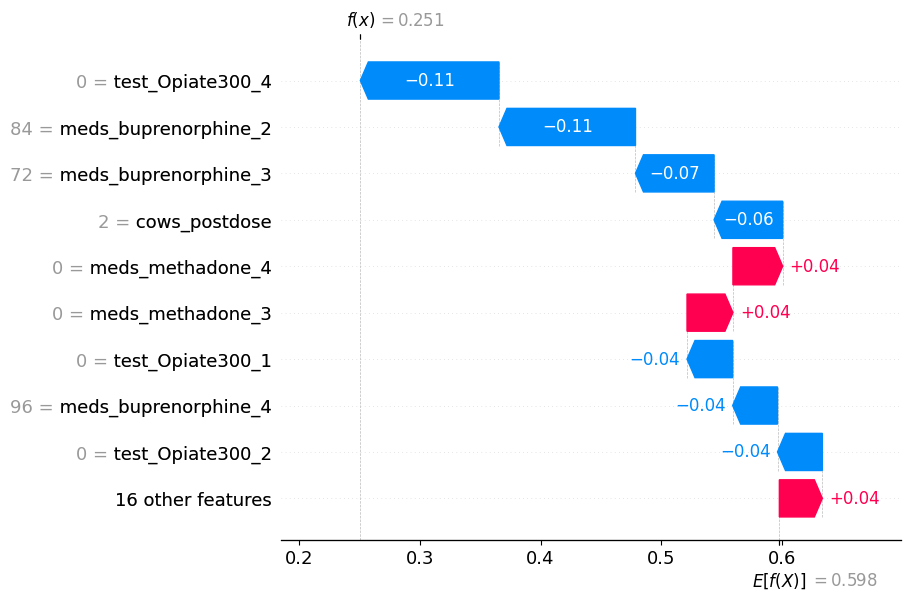

In [22]:
# waterfall plot for clas index 0 
class_index = 1
data_index = np.random.choice(shap_values.shape[0])

print(f'Class index: {class_index}')
print(f'Data index: {data_index}')

shap.plots.waterfall(shap_values[data_index,:,class_index])

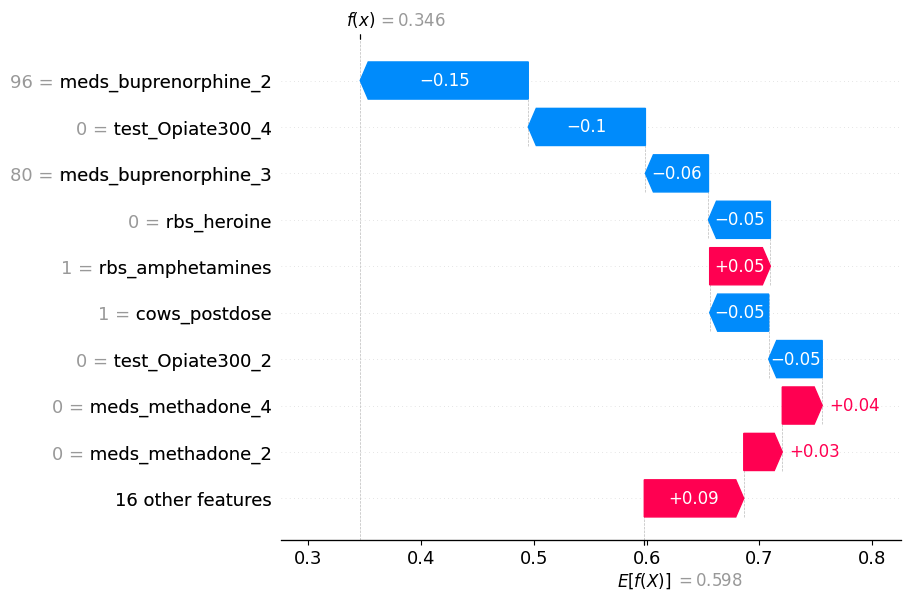

In [23]:
shap.plots.waterfall(shap_values[50,:,1])

Class index: 1
Data index: 78


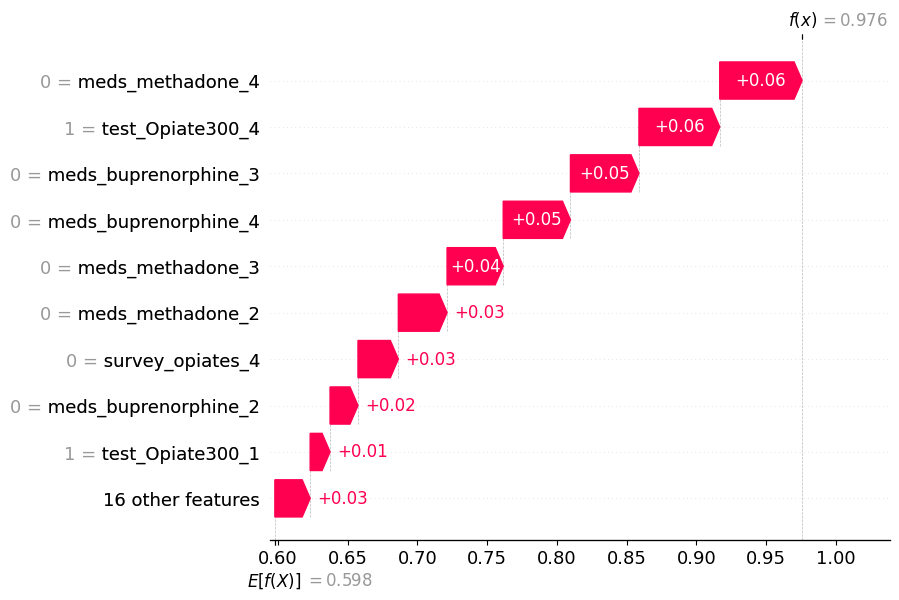

In [24]:
data_index = np.random.choice(shap_values.shape[0])
class_index = 1
print(f'Class index: {class_index}')
print(f'Data index: {data_index}')
shap.plots.waterfall(shap_values[data_index,:,class_index])

Class index: 1
Data index: 147


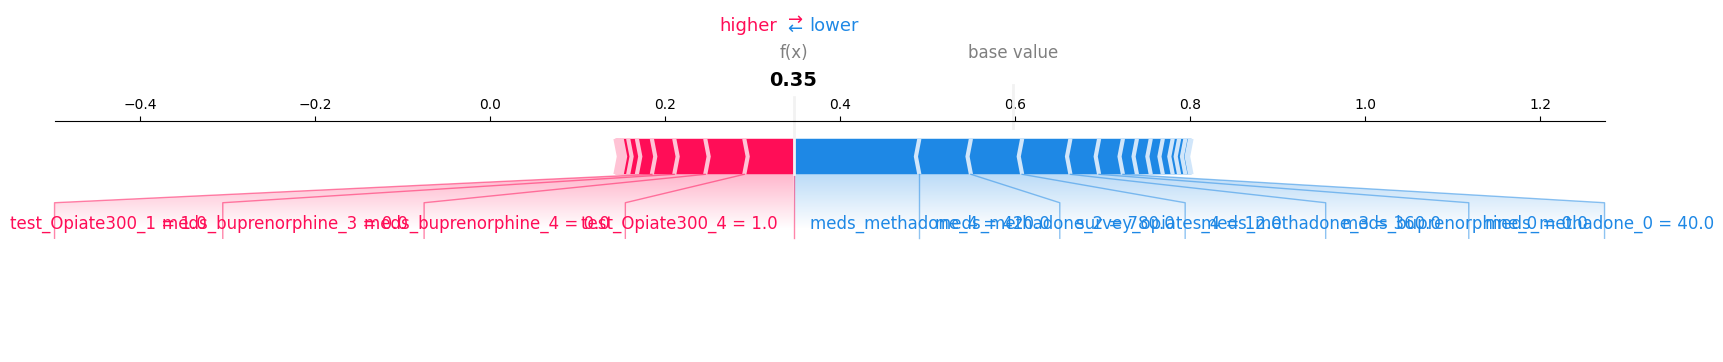

In [25]:
shap.initjs()

class_index = 1
data_index = np.random.choice(shap_values.shape[0])

print(f'Class index: {class_index}')
print(f'Data index: {data_index}')

shap.plots.force(shap_values[data_index,:,class_index], matplotlib=True, show=True)

Class index: 1


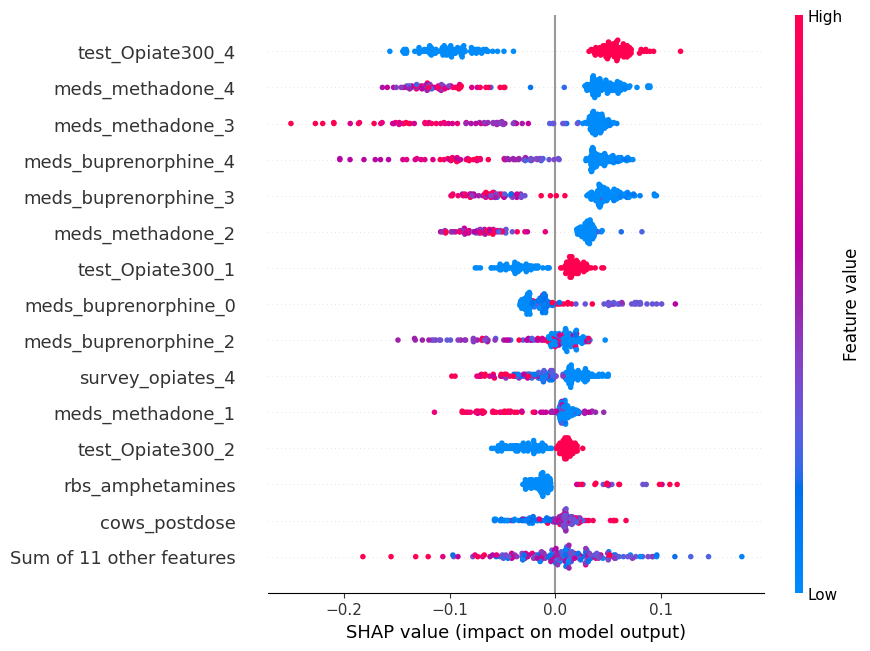

In [26]:
class_index = 1
print(f'Class index: {class_index}')

# shap beeswarm plot
shap.plots.beeswarm(shap_values[:,:,class_index], max_display=15, show=True)

In [27]:
X_test.columns

Index(['test_Opiate300_0', 'test_Opiate300_1', 'test_Opiate300_2',
       'test_Opiate300_3', 'test_Opiate300_4', 'survey_opiates_0',
       'survey_opiates_4', 'meds_methadone_0', 'meds_buprenorphine_0',
       'meds_methadone_1', 'meds_buprenorphine_1', 'meds_methadone_2',
       'meds_buprenorphine_2', 'meds_methadone_3', 'meds_buprenorphine_3',
       'meds_methadone_4', 'meds_buprenorphine_4', 'cows_predose',
       'cows_postdose', 'rbs_sexual_activity', 'rbs_cocaine', 'rbs_heroine',
       'rbs_amphetamines', 'rbs_other_opiates', 'gender'],
      dtype='object')

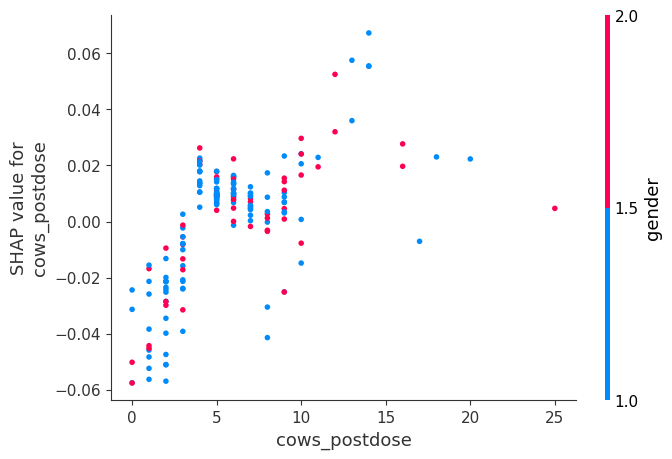

In [28]:
# Extract SHAP values for the dependence plot
shap_values_array = shap_values.values

# Create a dependence plot for a specific feature
shap.dependence_plot('cows_postdose', shap_values_array[:,:,1], X_test, interaction_index='gender', show=True)

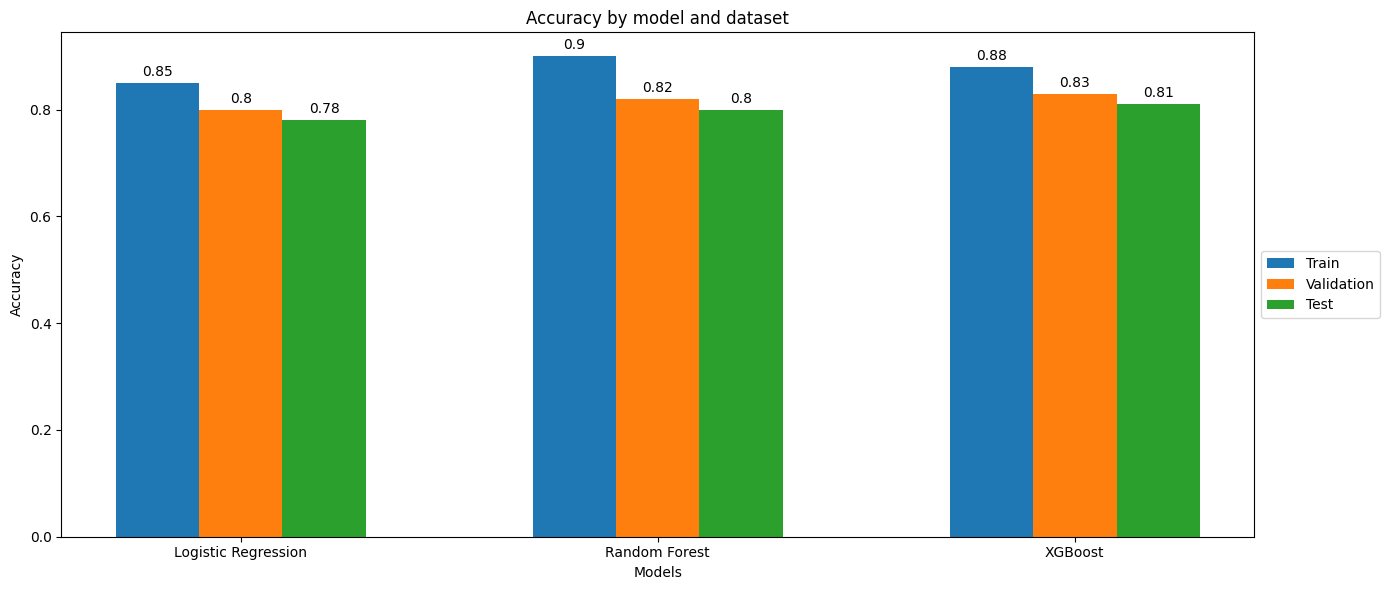

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the accuracies stored in the following dictionaries
accuracies = {
    'Logistic Regression': {
        'train': 0.85,
        'val': 0.80,
        'test': 0.78
    },
    'Random Forest': {
        'train': 0.90,
        'val': 0.82,
        'test': 0.80
    },
    'XGBoost': {
        'train': 0.88,
        'val': 0.83,
        'test': 0.81
    }
}

# Extract the data
models = list(accuracies.keys())
train_accuracies = [accuracies[model]['train'] for model in models]
val_accuracies = [accuracies[model]['val'] for model in models]
test_accuracies = [accuracies[model]['test'] for model in models]

# Set up the bar plot
x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(14, 6))
rects1 = ax.bar(x - width, train_accuracies, width, label='Train')
rects2 = ax.bar(x, val_accuracies, width, label='Validation')
rects3 = ax.bar(x + width, test_accuracies, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by model and dataset')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
# put legend outside of plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Attach a text label above each bar in rects, displaying its height.
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()